# 시간별 자건거 대여량 예측 모델

<details>
<summary>개요</summary>
설명   
Kaggle Scripts를 통해 이 대회를 시작하세요   

자전거 공유 시스템은      
도시 전역에 설치된 키오스크 네트워크를 통해    
회원 가입, 대여, 반납 과정이 자동화된 자전거 대여 방식입니다.    

이 시스템을 통해 사람들은 한 곳에서 자전거를 대여하고 필요에 따라 다른 곳에 반납할 수 있습니다.    
현재 전 세계적으로 500개가 넘는 자전거 공유 프로그램이 운영되고 있습니다.   

이러한 시스템에서 생성되는 데이터는 이동 시간, 출발지, 도착지, 그리고 경과 시간이 명확하게 기록되기 때문에 연구자들에게 매력적입니다.    
따라서 자전거 공유 시스템은 센서 네트워크 역할을 하며, 도시의 이동성 연구에 활용될 수 있습니다.    
이 대회에서 참가자들은 워싱턴 D.C.의 Capital Bikeshare 프로그램에서 자전거 대여 수요를 예측하기 위해    
과거 사용 패턴과 날씨 데이터를 결합해야 합니다.
</details>

<details>
<summary>컬럼 설명</summary>

| 컬럼명            | 설명                                                                          |
| -------------- | --------------------------------------------------------------------------- |
| **datetime**   | 날짜 및 시간 (예: 2011-01-01 00:00:00). 시계열 분석 및 시간 기반 특징 추출 가능 (연, 월, 요일, 시간 등). |
| **season**     | 계절 정보 (1: 봄, 2: 여름, 3: 가을, 4: 겨울). **주의**: 실제 날짜가 아닌 고정 분기 기준 (예: 1=3\~5월). |
| **holiday**    | 공휴일 여부 (0: 평일, 1: 공휴일). 미국의 공휴일을 기준으로 설정됨.                                  |
| **workingday** | 근무일 여부 (0: 주말 또는 공휴일, 1: 평일). 이 컬럼은 **holiday**와 **요일 정보**를 종합한 결과입니다.      |
| **weather**    | 날씨 상황 (1\~4 등급). 숫자가 높을수록 안 좋은 날씨를 의미함.                                     |
|                | - 1: 맑음, 구름 약간, 구름 많음 (좋은 날씨)                                               |
|                | - 2: 안개 + 구름 등 (보통 날씨)                                                      |
|                | - 3: 약한 눈 또는 비 등 (나쁜 날씨)                                                    |
|                | - 4: 폭우, 폭설, 안개 등 (매우 안 좋은 날씨)                                              |
| **temp**       | 실제 온도 (°C).                                                                 |
| **atemp**      | 체감 온도 (°C). **temp와 유사하지만 다름**.                                             |
| **humidity**   | 상대 습도 (%).                                                                  |
| **windspeed**  | 풍속 (보통 km/h 혹은 m/s). 일부 전처리된 데이터에서는 `windspeed=0`이 다수 포함됨.                  |
| **casual**     | 비회원(비등록 사용자)의 대여 수.                                                         |
| **registered** | 등록된 회원의 대여 수.                                                               |
| **count**      | 총 대여 수 (`casual + registered`). \*\*예측 타겟(target)\*\*으로 사용됨.                |


</details>

In [24]:

import pandas as pd 
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib as mpl

#폰트 지정
from matplotlib import rcParams
rcParams['font.family'] = 'Noto Sans KR'
rcParams['axes.unicode_minus'] = False


In [2]:
dt = pd.read_csv('data3/train.csv')
dt.info(), dt.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


(None,
               datetime  season  holiday  workingday  weather  temp   atemp  \
 0  2011-01-01 00:00:00       1        0           0        1  9.84  14.395   
 1  2011-01-01 01:00:00       1        0           0        1  9.02  13.635   
 
    humidity  windspeed  casual  registered  count  
 0        81        0.0       3          13     16  
 1        80        0.0       8          32     40  )

In [11]:
dt.info(), dt.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
 12  year        10886 non-null  int32         
 13  month       10886 non-null  int32         
 14  hour        10886 non-null  int32         
 15  dayofweek   10886 non-null  int32         
dtypes: datetime64[ns](1), 

(None,
                             datetime        season       holiday  \
 count                          10886  10886.000000  10886.000000   
 mean   2011-12-27 05:56:22.399411968      2.506614      0.028569   
 min              2011-01-01 00:00:00      1.000000      0.000000   
 25%              2011-07-02 07:15:00      2.000000      0.000000   
 50%              2012-01-01 20:30:00      3.000000      0.000000   
 75%              2012-07-01 12:45:00      4.000000      0.000000   
 max              2012-12-19 23:00:00      4.000000      1.000000   
 std                              NaN      1.116174      0.166599   
 
          workingday       weather         temp         atemp      humidity  \
 count  10886.000000  10886.000000  10886.00000  10886.000000  10886.000000   
 mean       0.680875      1.418427     20.23086     23.655084     61.886460   
 min        0.000000      1.000000      0.82000      0.760000      0.000000   
 25%        0.000000      1.000000     13.94000     16

In [22]:
# 컬럼명 - 한국어명 매핑
col_kor_map = {
    'season': '계절',
    'holiday': '공휴일 여부',
    'workingday': '근무일 여부',
    'weather': '날씨 상태',
    'temp': '온도',
    'atemp': '체감 온도',
    'humidity': '습도',
    'windspeed': '풍속'
}

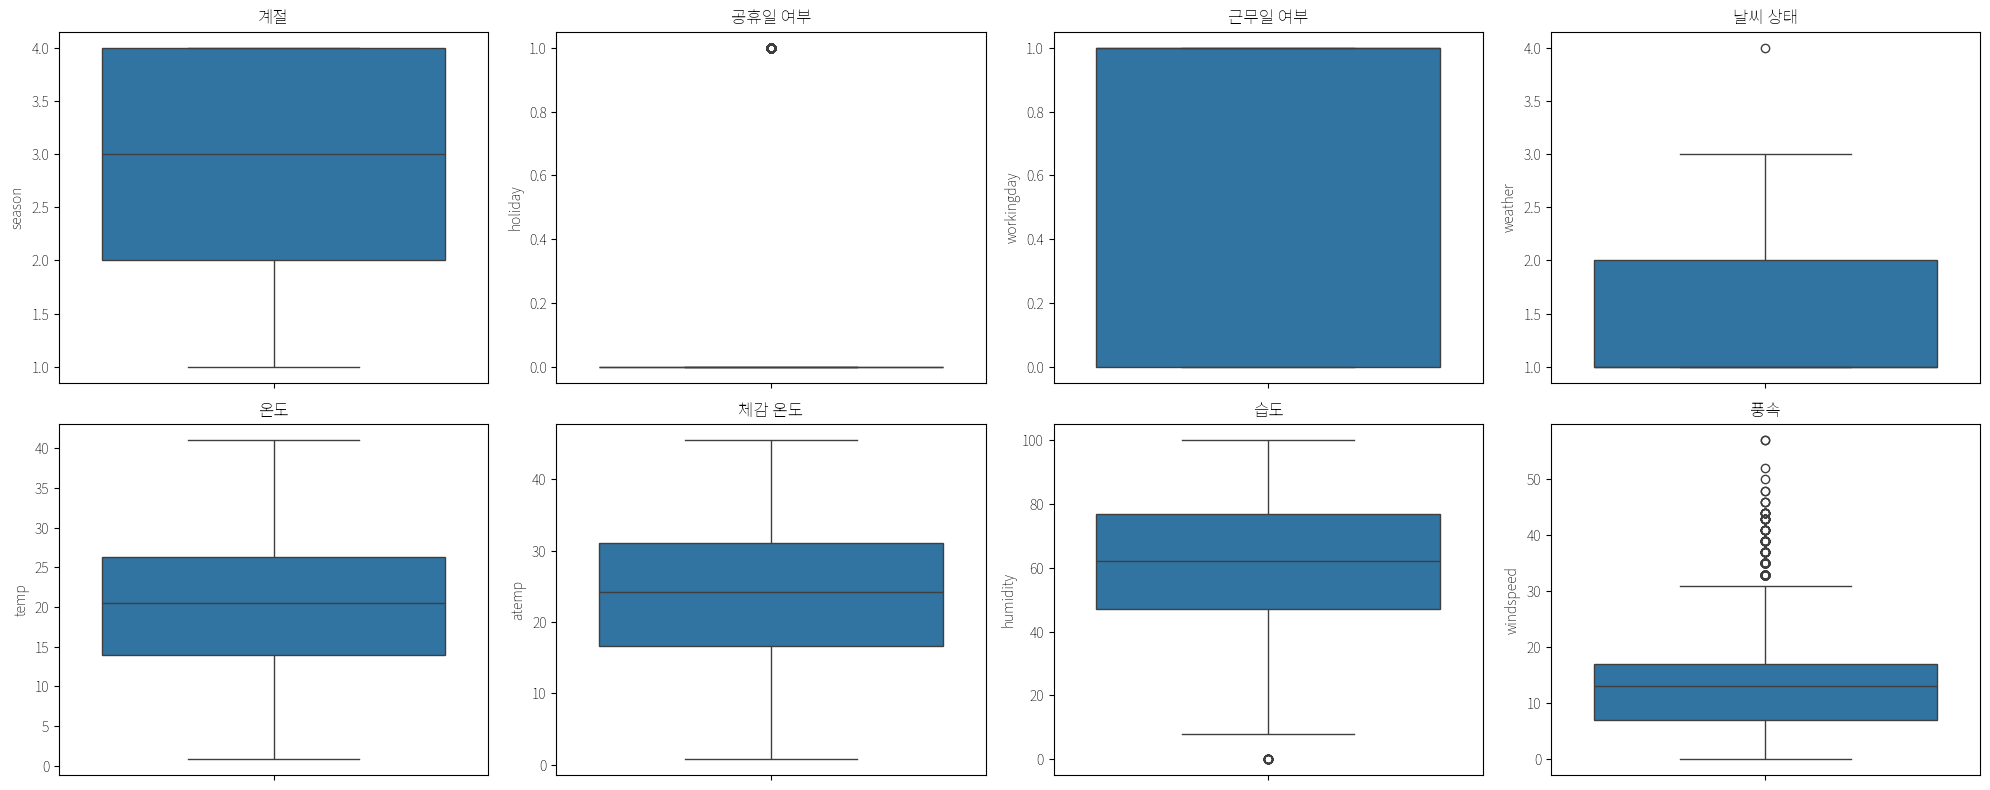

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# 시각화할 컬럼 리스트
li = ['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']

# 컬럼명 -> 한글 제목 매핑
col_kor_map = {
    'season': '계절',
    'holiday': '공휴일 여부',
    'workingday': '근무일 여부',
    'weather': '날씨 상태',
    'temp': '온도',
    'atemp': '체감 온도',
    'humidity': '습도',
    'windspeed': '풍속'
}

# 그리드 설정
n_cols = 4
n_rows = (len(li) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 4))

for i, col in enumerate(li, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=dt[col])  # 또는 x=dt[col] 으로 방향 변경 가능
    plt.title(f'{col_kor_map[col]}', fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
# 예시: 풍속 상위 이상치 제거
Q1 = dt['windspeed'].quantile(0.25)
Q3 = dt['windspeed'].quantile(0.75)
IQR = Q3 - Q1
upper = Q3 + 1.5 * IQR

dt = dt[dt['windspeed'] <= upper]

In [29]:
# 0인 값 중앙값으로 대체
dt.loc[dt['windspeed'] == 0, 'windspeed'] = dt[dt['windspeed'] != 0]['windspeed'].median()


In [4]:

# 오브젝트 데이터 'datetime' 인코딩

dt['datetime'] = pd.to_datetime(dt['datetime'])

dt['year'] = dt['datetime'].dt.year
dt['month'] = dt['datetime'].dt.month
dt['hour'] = dt['datetime'].dt.hour
dt['dayofweek'] = dt['datetime'].dt.dayofweek



In [5]:
x = dt.drop(columns=['count','datetime','casual','registered'], inplace=False)
y = dt['count'].values

In [6]:
xtrain, xtest, ytrain, ytest = train_test_split(x, y , test_size= 0.2, random_state=512)

In [7]:
x.info(), x.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   year        10886 non-null  int32  
 9   month       10886 non-null  int32  
 10  hour        10886 non-null  int32  
 11  dayofweek   10886 non-null  int32  
dtypes: float64(3), int32(4), int64(5)
memory usage: 850.6 KB


(None,
    season  holiday  workingday  weather  temp   atemp  humidity  windspeed  \
 0       1        0           0        1  9.84  14.395        81        0.0   
 1       1        0           0        1  9.02  13.635        80        0.0   
 
    year  month  hour  dayofweek  
 0  2011      1     0          5  
 1  2011      1     1          5  )

In [8]:
results = []

for degrees in range(1,5):
    model_poly = Pipeline([
    ('poly', PolynomialFeatures(degree=degrees, include_bias=False)),
    ('Linear',LinearRegression())]
)
    model_poly.fit(xtrain, ytrain)
    pred_poly = model_poly.predict(xtest)
    mse = mean_squared_error(ytest,pred_poly)
    rmse = np.sqrt(mse)
    r2 = r2_score(ytest, pred_poly)

    results.append({ 'degree': degrees,
                'mse' : mse, 
                'RMSE' : rmse,
                'R2' : r2})

In [9]:
pd.DataFrame(results)

,degree,mse,RMSE,R2
0,1,21298.777472,145.941007,0.389444
1,2,15696.993347,125.287642,0.550026
2,3,12907.005055,113.609001,0.630005
3,4,34521.946481,185.800825,0.010385
